## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [153]:
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

In [154]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # significance level
    z_crit = -norm.ppf(alpha/2) # z critical
    
    print(f"z_crit: {'%.2f' % z_crit}")
    
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 # eps
    lower_bound = x_p - eps # lower bound
    upper_bound = x_p + eps # upper bound
    
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma  # significance level
    diff = xp[1] - xp[0] # sample conversion diff
    z_crit = -norm.ppf(alpha/2) # z critical
    
    print(f"z_crit: {'%.2f' % z_crit}")
    
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # eps
    lower_bound = diff - eps # lower bound
    upper_bound = diff + eps # upper bound
    
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

def conf_interval(n, x_mean, x_std, gamma=0.95):
    alpha = 1 - gamma # significance level
    k = n - 1 # degree of freedom
    t_crit = -t.ppf(alpha/2, k) # t-критическое
    
    print(f"t_crit: {'%.2f' % t_crit}")
    
    eps = t_crit * x_std/(n ** 0.5) # eps
    lower_bound = x_mean - eps # lower bound
    upper_bound = x_mean + eps # upper bound
    
    return (round(lower_bound, 2), round(upper_bound, 2))

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [155]:
data = pd.read_csv('ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [156]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


**Столбец date имеет тип данных object, так как представлен в виде строки**

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [157]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

grouped = data.groupby(['group'], as_index=False, )['date'].agg(['min', 'max'])

grouped


,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


C 2 по 24 января 2021 года

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [158]:
print('Group A:')
print(f"Total users: {data[data['group'] == 'A']['user_id'].count()}")
print(f"Total purchases: {data[data['group'] == 'A']['purchase'].sum()}")
print(f"Total price: {data[data['group'] == 'A']['price'].sum()}")
print('Group B:')
print(f"Total users: {data[data['group'] == 'B']['user_id'].count()}")
print(f"Total purchases: {data[data['group'] == 'B']['purchase'].sum()}")
print(f"Total price: {data[data['group'] == 'B']['price'].sum()}")

Group A:
Total users: 147202
Total purchases: 17723
Total price: 1436260000
Group B:
Total users: 147276
Total purchases: 17514
Total price: 1554100000


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

In [159]:
intersection = set(data[data['group'] == 'A']['user_id']).intersection(
    set(data[data['group'] == 'B']['user_id'])
)

print(f"Number of users in both groups: {len(intersection)}")

Number of users in both groups: 1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

In [160]:
updated_data = data[data['user_id'].apply(lambda x: x not in intersection)].copy()

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

![image.png](https://i.ibb.co/KszTYTs/Screen-Shot-2022-05-24-at-00-28-41.png)
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

Чему на этот раз равно количество посещений сайта в группах А и B?

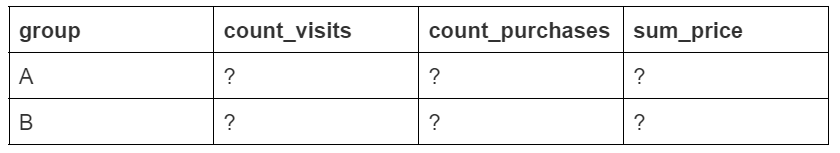

In [161]:
grouped_sum = updated_data.groupby(['group']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'    
}).rename(columns={
    'user_id': 'count_visits',
    'purchase': 'count_purchases',
    'price': 'sum_price'
})

grouped_sum

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

**Из таблицы выше можно видеть, что данные в выборке достаточно сбалансированы. Кол-во посещений и заказов в обеих группах почти идентичны. Но уже можно видеть, что хоть кол-во заказов в группе А немного больше, средний чек в группе Б выше.**

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [162]:
grouped_sum['conversion'] = grouped_sum['count_purchases'] / grouped_sum['count_visits'] * 100
grouped_sum['mean_check'] = grouped_sum['sum_price'] / grouped_sum['count_purchases']

grouped_sum

,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417780000,12.034520,81076.228055
B,145381,17290,1533010000,11.892888,88664.545980


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

**Из таблицы выше видно, что вариант А эффективнее в конверсии - пользователи чаще делают заказы на этой версии сайта. Однако в группе Б средний чек выше, хоть и конверсия меньше. На данном этапе еще рано говорить, какой вариант лучше, нужно провести статистические тесты, чтобы подтвердить значимость.**

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [163]:
pivot = pd.pivot_table(updated_data, index='group', columns='price', values='purchase', aggfunc='sum')
pivot.drop(labels=0, axis=1, inplace=True)

pivot

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

In [164]:
fig = px.imshow(
    pivot,
    title='Тепловая карта кол-ва покупок в каждой группе в разных ценовых категориях'
)
fig.show()

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

**По тепловой карте выше, можно сказать, что покупательская способность обеих групп почти идентична в ценовых категориях билетов равной 10к и 150к. Однако для туров по 60к у пользователей группы А большая покупательная способность. С другой стороны, для туров по 100к у группы Б покупательная способность, что объясняет больший средний чек.**

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [165]:
grouped = updated_data.groupby(['date', 'group'], as_index=False).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).rename(columns={
    'user_id': 'count_visits',
    'purchase': 'count_purchases',
    'price': 'sum_price'
})

grouped['conversion'] = grouped['count_purchases'] / grouped['count_visits'] * 100
grouped['mean_check'] = grouped['sum_price'] / grouped['count_purchases']

conv       = list(grouped[grouped['date'] == '2021-01-03']['conversion'])
mean_check = list(grouped[grouped['date'] == '2021-01-03']['mean_check'])

print(f"Conversion for 2021-01-03 - A: {round(conv[0], 2)}, B: {round(conv[1], 2)}")
print(f"Mean check for 2021-01-03 - A: {round(mean_check[0])}, B: {round(mean_check[1])}")

grouped.head()

Conversion for 2021-01-03 - A: 11.34, B: 11.39
Mean check for 2021-01-03 - A: 82888, B: 87480


,date,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [166]:
grouped['cum_count_visits']    = grouped.groupby(['group'])['count_visits'].cumsum()
grouped['cum_count_purchases'] = grouped.groupby(['group'])['count_purchases'].cumsum()
grouped['cum_sum_price']       = grouped.groupby(['group'])['sum_price'].cumsum()

grouped['cum_conversion'] = grouped['cum_count_purchases'] / grouped['cum_count_visits'] * 100
grouped['cum_mean_check'] = grouped['cum_sum_price'] / grouped['cum_count_purchases']

cum_conv       = float(grouped[(grouped['date'] == '2021-01-20') & (grouped['group'] == 'B')]['cum_conversion'])
cum_mean_check = float(grouped[(grouped['date'] == '2021-01-12') & (grouped['group'] == 'A')]['cum_mean_check'])

print(f"Cum Conversion for 2021-01-20 for Group B: {round(cum_conv, 2)}")
print(f"Cum Mean check for 2021-01-03 for Group A: {round(cum_mean_check)}")

grouped.head()

Cum Conversion for 2021-01-20 for Group B: 11.9
Cum Mean check for 2021-01-03 for Group A: 81492


,date,group,count_visits,count_purchases,sum_price,conversion,mean_check,cum_count_visits,cum_count_purchases,cum_sum_price,cum_conversion,cum_mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535,9450,1107,91410000,11.714286,82574.525745
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101,9480,1099,95620000,11.592827,87006.369427
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270,16016,1906,155660000,11.900599,81668.415530


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

In [167]:
fig1 = px.line(
    grouped,
    x='date',
    y='cum_conversion',
    color='group',
     title='Cumulative conversion by day'
)
fig2 = px.line(
    grouped,
    x='date',
    y='cum_mean_check',
    color='group',
     title='Cumulative mean cheack by day'
)

fig1.show()
fig2.show()

**Графики выше показывают, что обе метрики со временем стабилизировались. Кумулятивные показатели подтверждаются полученными данными выше - конверсия выше в группе А, а средний чек выше в группе Б.
Я думаю, что на этом этапе можно сказать, что A/B тест завершен, осталось провести статистические тесты.**

In [168]:
a = updated_data[updated_data['group'] == 'A']
b = updated_data[updated_data['group'] == 'B']

grouped_a = grouped[grouped['group'] == 'A']
grouped_b = grouped[grouped['group'] == 'B']

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [179]:
converted_piv = updated_data.groupby('group')['purchase'].agg(
    ['sum', 'count']
)

H0 = 'Conversions in groups A and B are equal'
Ha = 'The conversion rate in Group A is higher than the conversion rate in Group B'

alpha  = 0.05

_, p = proportions_ztest(
    count=converted_piv['sum'],
    nobs=converted_piv['count'],
    alternative='larger'
)

print(f"p={'%.3f' % p}: {H0 if p > alpha else Ha}")

p=0.120: Conversions in groups A and B are equal


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

**По результатам Z-теста для пропорций, в данной выборке отсутствует статистическая разница между конверсиями в группах А и Б.**

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [170]:
conf_interval_a = proportions_conf_interval(
    n=a['user_id'].count(), 
    x_p=a['purchase'].mean() 
)
conf_interval_b = proportions_conf_interval(
    n=b['user_id'].count(), 
    x_p=b['purchase'].mean()
)

print('Confidence interval for group A conversion: {}'.format(conf_interval_a))
print('Confidence interval for group B conversion: {}'.format(conf_interval_b))

n = [a['user_id'].count(), b['user_id'].count()]
x_p = [a['purchase'].mean(), b['purchase'].mean()]

print('Confidence interval for conversion diff: {}'.format(diff_proportions_conf_interval(n, x_p)))

z_crit: 1.96
z_crit: 1.96
Confidence interval for group A conversion: (11.87, 12.2)
Confidence interval for group B conversion: (11.73, 12.06)
z_crit: 1.96
Confidence interval for conversion diff: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

**По результатам доверительных интервалов, конверсия в группах А и Б пересекаются, что говорит о том, что статистической разницы нету. Это подтверждается доверительным интервалом для разницы, что пересекает 0, что говорит, что конверсии равны.**

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [171]:
H0 = 'mean_check is distributed normally'
Ha = 'mean_check is not distributed normally'

alpha = 0.05

_, pa = shapiro(grouped[grouped['group'] == 'A']['mean_check'])
_, pb = shapiro(grouped[grouped['group'] == 'B']['mean_check'])

print(f"pa={'%.3f' % pa}: {H0 if pa > alpha else Ha} in Group A")
print(f"pb={'%.3f' % pb}: {H0 if pb > alpha else Ha} in Group B")

pa=0.253: mean_check is distributed normally in Group A
pb=0.094: mean_check is distributed normally in Group B


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [178]:
H0 = 'The daily mean check in Group A is equal to check in Group B'
Ha = 'The daily mean check in Group A is less than in Group B'

alpha = 0.05

_, p = ttest_ind(
    grouped[grouped['group'] == 'A']['mean_check'],
    grouped[grouped['group'] == 'B']['mean_check'],
    alternative='less'
)

print(f"p={'%.3f' % p}: {H0 if p > alpha else Ha}")

p=0.000: The daily mean check in Group A is less than in Group B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

**T-тест показал, что в данных о среднем чеке есть статистическая разница и что средний чек в среднем выше в группе Б.**

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [173]:
n_a = grouped_a.shape[0] # sample size
x_mean_a = grouped_a['mean_check'].mean() # sample mean
x_std_a = grouped_a['mean_check'].std() # std

n_b = grouped_b.shape[0] # sample size
x_mean_b = grouped_b['mean_check'].mean() # sample mean
x_std_b = grouped_b['mean_check'].std() # std

print('Confidence interval of mean check in Group A: {}'.format(conf_interval(n_a, x_mean_a, x_std_a)))
print('Confidence interval of mean check in Group A: {}'.format(conf_interval(n_b, x_mean_b, x_std_b)))

t_crit: 2.07
Confidence interval of mean check in Group A: (79630.35, 82308.22)
t_crit: 2.07
Confidence interval of mean check in Group A: (87625.83, 89525.61)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

**Полученные интервалы не пересекаются, что говорит о том, что, статистически, средний чек в группе Б выше.**

## Сделайте общий вывод по результатам A/B-теста

**Анализ метрик и статистических тестов показал, что конверсия в группах А и Б равна, но более важно то, что в группе Б средний чек выше, что говорит о том, что выручка компании может вырасти, хоть конверсия и останеться на том же уровне. Поэтому я думаю, что вариант Б стоить пустить в массы - он более эффективен.**